In [92]:
""" Writing my first randomforest code.
Author : AstroDave
Date : 23rd September 2012
Revised: 15 April 2014
please see packages.python.org/milk/randomforests.html for more

""" 
import pandas as pd
import numpy as np
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
# TRAIN DATA
train_df = pd.read_csv('/Users/dekedor/Downloads/train.csv', header=0)        # Load the train file into a dataframe

train_df['Gender'] = train_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

if len(train_df.Embarked[ train_df.Embarked.isnull() ]) > 0:
    train_df.loc[ (train_df.Embarked.isnull()) , \
                'Embarked'] = train_df.Embarked.dropna().mode().values

Ports = list(enumerate(np.unique(train_df['Embarked'])))    # determine all values of Embarked,
Ports_dict = { name : i for i, name in Ports }              # set up a dictionary in the form  Ports : index
train_df.Embarked = train_df.Embarked.map( lambda x: Ports_dict[x]).astype(int)     # Convert all Embark strings to int

median_age = train_df['Age'].dropna().median()
if len(train_df.Age[ train_df.Age.isnull() ]) > 0:
    train_df.loc[ (train_df.Age.isnull()), 'Age'] = median_age

train_df = train_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 

In [94]:
# TEST DATA
test_df = pd.read_csv('/Users/dekedor/Downloads/test.csv', header=0)        # Load the test file into a dataframe

test_df['Gender'] = test_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

if len(test_df.Embarked[ test_df.Embarked.isnull() ]) > 0:
    test_df.Embarked[ test_df.Embarked.isnull() ] = test_df.Embarked.dropna().mode().values

test_df.Embarked = test_df.Embarked.map( lambda x: Ports_dict[x]).astype(int)

# All the ages with no data -> make the median of all Ages
median_age = test_df['Age'].dropna().median()
if len(test_df.Age[ test_df.Age.isnull() ]) > 0:
    test_df.loc[ (test_df.Age.isnull()), 'Age'] = median_age

# All the missing Fares -> assume median of their respective class
if len(test_df.Fare[ test_df.Fare.isnull() ]) > 0:
    median_fare = np.zeros(3)
    for f in range(0,3):                                              # loop 0 to 2
        median_fare[f] = test_df[ test_df.Pclass == f+1 ]['Fare'].dropna().median()
    for f in range(0,3):                                              # loop 0 to 2
        test_df.loc[ (test_df.Fare.isnull()) & (test_df.Pclass == f+1 ), 'Fare'] = median_fare[f]

In [95]:
# Collect the test data's PassengerIds before dropping it
ids = test_df['PassengerId'].values
# Remove the Name column, Cabin, Ticket, and Sex (since I copied and filled it to Gender)
test_df = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 


# The data is now ready to go. So lets fit to the train, then predict to the test!
# Convert back to a numpy array
train_data = train_df.values
test_data = test_df.values

print 'Training...'
forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit( train_data[0::,1::], train_data[0::,0] )

print 'Predicting...'
output = forest.predict(test_data).astype(int)


predictions_file = open("/Users/dekedor/Downloads/myfirstforest.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Training...
Predicting...
Done.


In [96]:
print 'Training...'
lr = LogisticRegression()
lr = lr.fit( train_data[0::,1::], train_data[0::,0] )

Training...


In [97]:
predictions_file = open("/Users/dekedor/Downloads/lr.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'
print(train_df.info())

Done.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int64
Gender      891 non-null int64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB
None


In [98]:
# let's add quadratic features
train_df = train_df.drop(['Embarked', 'Parch', 'SibSp', 'Age'], axis = 1)
test_df = test_df.drop(['Embarked', 'Parch', 'SibSp', 'Age'], axis = 1)
m = np.shape(train_df)
keys = train_df.keys()
for i in range(m[1]):
    for j in range(i):
        if not keys[i] == 'Survived' and \
        not keys[j] == 'Survived':
            field = '%s_%s' % (keys[i], keys[j])
            train_df[field] = train_df[keys[i]] * train_df[keys[j]]
m = np.shape(train_df)
keys = train_df.keys()
for i in range(m[1]):
    for j in range(i):
        if not keys[i] == 'Survived' and \
        not keys[j] == 'Survived':
            field = '%s_%s' % (keys[i], keys[j])
            train_df[field] = train_df[keys[i]] * train_df[keys[j]]
m = np.shape(train_df)
keys = train_df.keys()
for i in range(m[1]):
    for j in range(i):
        if not keys[i] == 'Survived' and \
        not keys[j] == 'Survived':
            field = '%s_%s' % (keys[i], keys[j])
            train_df[field] = train_df[keys[i]] * train_df[keys[j]]

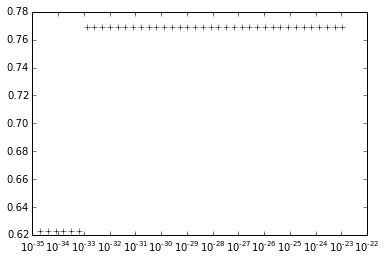

In [101]:
# use a small subset for training
train_data = train_df.values
reg = 1e-35
num_trials = 40
accuracy = np.zeros(num_trials)
regularization = np.zeros(num_trials)
for i in range(num_trials):
    reg = reg * 2
    lr = LogisticRegression(C = reg)
    lr = lr.fit(train_data[0:535,1::], train_data[0:535,0])
    correct = 0
    for j in range(len(train_data[536::, 0])):
        correct = correct + np.int64(lr.predict(train_data[j+536][1:]) == train_data[j+536][0])
    accuracy[i] = float(correct)/len(train_data[536::, 0])
    regularization[i] = reg
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(regularization, accuracy, 'k+')
ax.set_xscale('log')

In [108]:
lr = LogisticRegression(C = 1e-5)
lr = lr.fit(train_data[0:535,1::], train_data[0:535,0])

# let's add quadratic features
m = np.shape(test_df)
keys = test_df.keys()
for i in range(m[1]):
    for j in range(i):
        if not keys[i] == 'Survived' and \
        not keys[j] == 'Survived':
            field = '%s_%s' % (keys[i], keys[j])
            test_df[field] = test_df[keys[i]] * test_df[keys[j]]

# let's add quadratic features
m = np.shape(test_df)
keys = test_df.keys()
for i in range(m[1]):
    for j in range(i):
        if not keys[i] == 'Survived' and \
        not keys[j] == 'Survived':
            field = '%s_%s' % (keys[i], keys[j])
            test_df[field] = test_df[keys[i]] * test_df[keys[j]]
            
test_data = test_df.values
            
output = lr.predict(test_data).astype(int)
predictions_file = open("/Users/dekedor/Downloads/lr.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Done.
